<a href="https://colab.research.google.com/github/StavroK/MtySaturdayAI2020/blob/master/Fakenews_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [241]:
# navidate to packages library of your colab using the following command
%cd /usr/local/lib/python3.6/dist-packages

/usr/local/lib/python3.6/dist-packages


In [242]:
# use these commands to install and check installation

# ! pip install git+https://github.com/locationofpackage
# ! pip show nameofpackage

# we are checking for the following packages required to execute our code

# matplotlib - extension of NumPy enables you to embed plots into applications
# pandas - used to clean, transform, manipulate and analize data
# pickle - used to convert a python object into a character stream
# pip - used to manage installation and updates of python packages
# seaborn - based on matplotlib is used to vizualize example lenght by category 
# warnings - used to hide warinings coming from seaborn package

! pip show matplotlib
! pip show pandas
! pip show seaborn
! pip show warnings


Name: matplotlib
Version: 3.2.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /usr/local/lib/python3.6/dist-packages
Requires: cycler, pyparsing, numpy, python-dateutil, kiwisolver
Required-by: yellowbrick, seaborn, scikit-image, plotnine, pandas-profiling, mlxtend, mizani, missingno, matplotlib-venn, keras-vis, imgaug, fbprophet, fastai, descartes, daft
Name: pandas
Version: 1.0.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: None
Author-email: None
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: python-dateutil, pytz, numpy
Required-by: xarray, vega-datasets, statsmodels, sklearn-pandas, seaborn, pymc3, plotnine, pandas-profiling, pandas-gbq, pandas-datareader, mlxtend, mizani, gspread-dataframe, google-colab, fix-yahoo-finance, featuretools, fbprophet, f

**Data Set Analysis**

In this step we will check for a balanced data so we can train the machine learning models without oversampling or undersampling classes. If we see some bias towards one class we need to apply techniques to manage this issue with our data set.

First step is to check if we have all Python packages we need be using to visualize the characteristics of the dataset to check for class balance, and install those missing if any. We will need to join files containing labeling of examples to content of articles for our purpose.


We want to check for: 1. Number of examples in each class, 2. Total Percentage of examples in each class, 3. Distribution of the lenght of each example as we will use its word content to train for classification.


In [0]:
# This command will show you the "Location" of your package
# I am using numpy as is the most common package 
#! pip show numpy

Now that we have secured environment requirements for python packages that will be declared in the code, next we will import them into the program

In [244]:
%cd /usr/local/lib/python3.6/dist-packages
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import seaborn as sns
import warnings

/usr/local/lib/python3.6/dist-packages


We want to check for: 1. Number of examples in each class, 2. Total Percentage of examples in each class, 3. Distribution of the lenght of each example as we will use its word content to train for classification.

Data is already included in /content/FakeNews folder. Data is already separated by example content and labeled files, and also in train, test and demo files to keep process clean.


To upload trainning examples (which are stored in CSV )files is from the GitHub repository. Click on the dataset in repository, then click on View Raw. Copy the link to the raw dataset and store it as a string variable then to load the link into Pandas read_csv to get the data frame.

In [0]:
import pandas as pd
data = []
train_df=[]
trainbodies_df = []
trainstances_df = []

In [0]:
trainbodies_url = 'https://raw.githubusercontent.com/StavroK/MtySaturdayAI2020/master/train_bodies.csv'
trainbodies_df = pd.read_csv(trainbodies_url)

In [0]:
trainstances_url = 'https://raw.githubusercontent.com/StavroK/MtySaturdayAI2020/master/train_stances.random.csv'
trainstances_df = pd.read_csv(trainstances_url)

In [248]:
print("Total stances: " + str(len(trainbodies_df)))
print("Total bodies: " + str(len(trainstances_df)))

Total stances: 1683
Total bodies: 49972


In [249]:
trainbodies_df.columns


Index(['Body ID', 'articleBody'], dtype='object')

In [250]:
trainbodies_df.sort_values(by='Body ID')
trainbodies_df.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [251]:
trainstances_df.columns

Index(['Headline', 'Body ID', 'Stance'], dtype='object')

In [252]:
trainstances_df.sort_values(by='Body ID')
trainstances_df.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,discuss
1,Hundreds of Palestinians flee floods in Gaza a...,158,discuss
2,"Christian Bale passes on role of Steve Jobs, a...",137,disagree
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,disagree
4,Spider burrowed through tourist's stomach and ...,1923,agree


In [253]:
train_df = pd.merge(trainbodies_df,trainstances_df, on="Body ID")
print("Total training examples: " + str(len(train_df)))

Total training examples: 49972


In [254]:
train_df.columns

Index(['Body ID', 'articleBody', 'Headline', 'Stance'], dtype='object')

In [255]:
train_df.head()

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",discuss
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,disagree
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,agree
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,agree


In [256]:
train_df.tail()

,Body ID,articleBody,Headline,Stance
49967,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",disagree
49968,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",unrelated
49969,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",discuss
49970,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,disagree
49971,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,agree


In [0]:
data = []
data = train_df['Stance']

In [258]:
data.head()

0      discuss
1     disagree
2        agree
3    unrelated
4        agree
Name: Stance, dtype: object

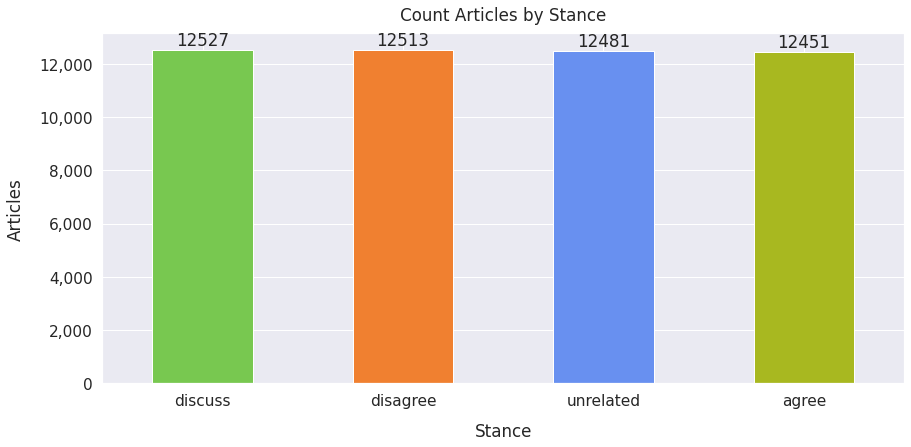

In [259]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import seaborn as sns

pkmn_type_colors = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]
fmt = '{x:,.0f}'
plt.figure(figsize=(12.8,6))
ax = data.value_counts().plot(kind='bar', color=pkmn_type_colors,rot=0)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
for p in ax.patches: 
    ax.annotate (np.round(p.get_height(),decimals=2), 
              (p.get_x()+p.get_width()/2., p.get_height()), 
              ha='center', va='center', xytext=(0, 10), 
              textcoords='offset points')
  
plt.xlabel("Stance", labelpad=14)
plt.ylabel("Articles", labelpad=14)
plt.title("Count Articles by Stance", y=1.02);


In [260]:
train_df['id'] = 1
data_2 = train_df.groupby('Stance').count()['id'].reset_index(level='Stance')
TotalArticles = data_2['id'].sum()
print("Total Articles: "+ str(TotalArticles))
data_2['Percent of Total'] = data_2['id']*100 / TotalArticles
print(data_2)

Total Articles: 49972
      Stance     id  Percent of Total
0      agree  12451         24.915953
1   disagree  12513         25.040022
2    discuss  12527         25.068038
3  unrelated  12481         24.975987


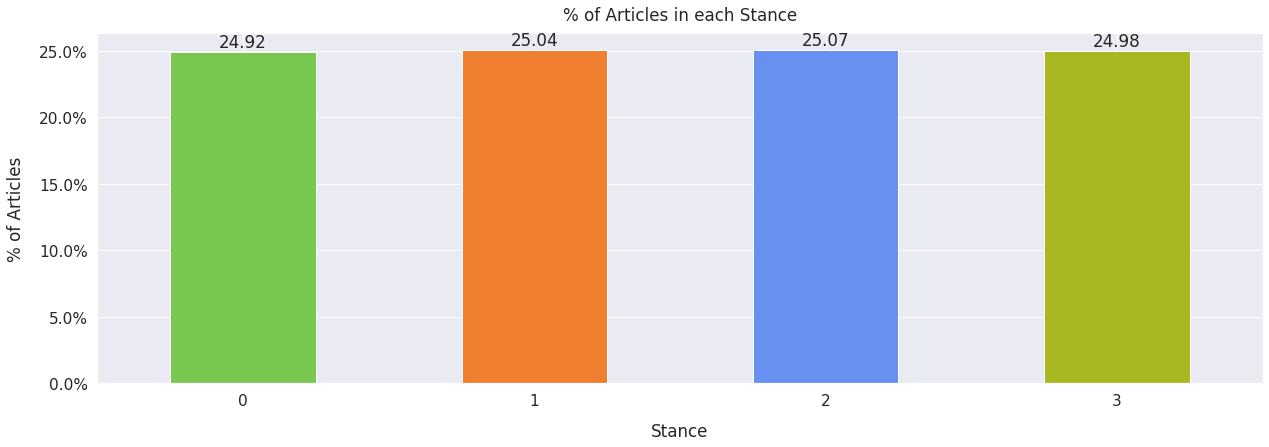

In [261]:
plt.figure(figsize=(18.6,6))
labels = data_2['Stance']
ax= data_2['Percent of Total'].plot(kind='bar', color=pkmn_type_colors,rot=0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches: 
  ax.annotate(np.round(p.get_height(),decimals=2), 
              (p.get_x()+p.get_width()/2., p.get_height()), 
              ha='center', va='center', xytext=(0, 10), 
              textcoords='offset points')
plt.xlabel("Stance", labelpad=14)
plt.ylabel("% of Articles", labelpad=14)
plt.title("% of Articles in each Stance", y=1.02);

Checking Article Body lenght to review is there is not a big diffence. This is important as during feature creation process may take total number of words

In [0]:
train_df['Article_lenght'] = train_df['articleBody'].str.len()

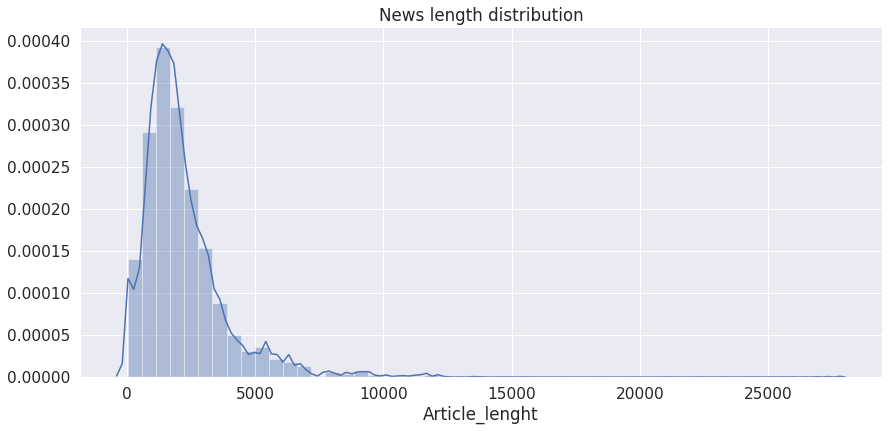

In [263]:
plt.figure(figsize=(12.8,6))
sns.distplot(train_df['Article_lenght']).set_title('News length distribution');

In [264]:
train_df['Article_lenght'].describe()

count    49972.000000
mean      2207.547266
std       1676.838550
min         38.000000
25%       1175.000000
50%       1824.000000
75%       2765.000000
max      27579.000000
Name: Article_lenght, dtype: float64

Now we will focus on 95% percentile to better appreciate examples' behaviour for lenght

In [265]:
quantile_95 = train_df['Article_lenght'].quantile(0.95)
train_df_95 = train_df[train_df['Article_lenght'] < quantile_95]
print("95% percentile Article Lenght threshold: " + str(quantile_95))

95% percentile Article Lenght threshold: 5501.0


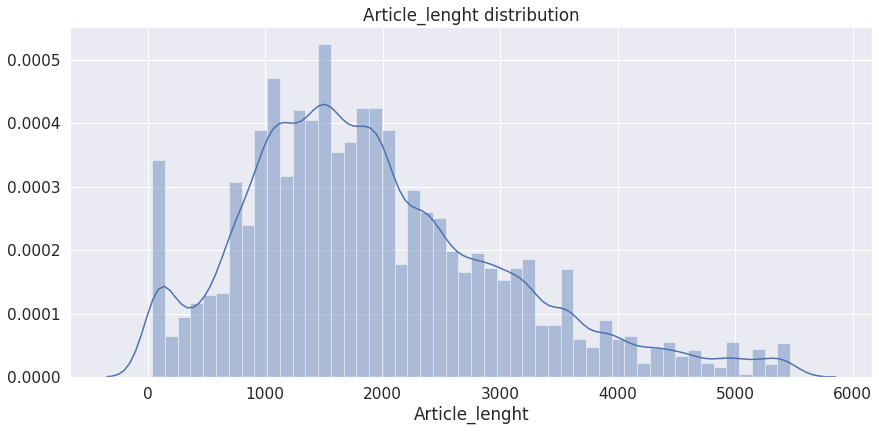

In [266]:
plt.figure(figsize=(12.8,6))
sns.distplot(train_df_95['Article_lenght']).set_title('Article_lenght distribution');

Next we will like to know how many articles are over 95% percentail in thier character count for article body. We do this just to understand data before feature engineering

In [267]:
train_df__more_quantile95 = train_df[train_df['Article_lenght'] > quantile_95]
print("Total Articles are above 95% quantile word count threshold: " + str(len(train_df__more_quantile95)))

Total Articles are above 95% quantile word count threshold: 2407


Let's use a BOX PLOT chart vizualitation to understand length distribution in every Stance class

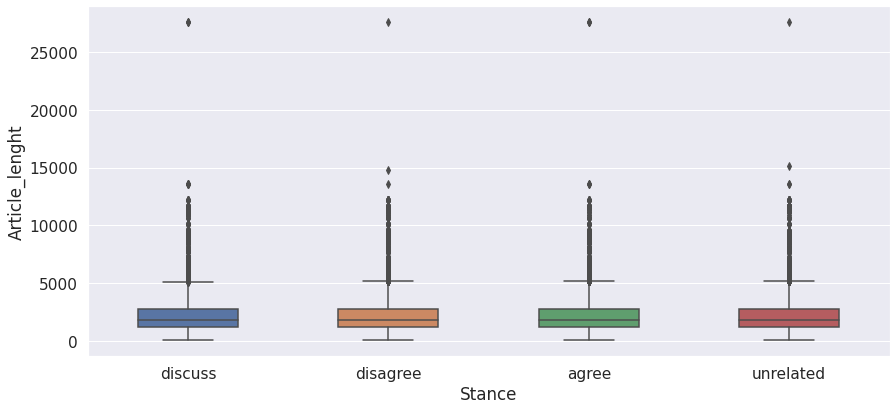

In [268]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=train_df, x='Stance', y='Article_lenght', width=.5);

We will use the same approach as histogram, and focus on 95% percentile using the train_df_95 dataframe 

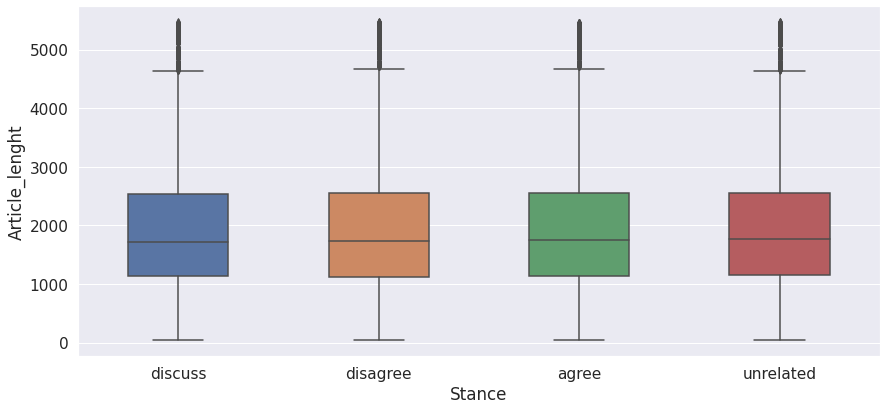

In [269]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=train_df_95, x='Stance', y='Article_lenght', width=.5);

Now we will save the data set in a pickle to convert the Train DataFrame into a byte stream to store the train data for furure use. Remember that train data resulted from joinning files, so we must store it as a different file